In [1]:
import pandas as pd
import pickle

In [2]:
palabras_lemm = 'palabras.pickle'
with open(palabras_lemm, "rb") as f:
    df_lemmas = pickle.load(f)

In [3]:
colores_grupos = {
    'Grupo Parlamentario Ciudadanos':'#FF571F',
    'Grupo Parlamentario Confederal de Unidas Podemos-En Comú Podem-Galicia en Común':'#693279',
    'Grupo Parlamentario Popular en el Congreso': '#184A90',
    'Grupo Parlamentario Socialista': '#DC0612',
    'Grupo Parlamentario VOX': '#63BE21'
}
color_otro = '#ACB0B2'

In [4]:
with open('nuevas_polaridades.pickle', "rb") as f:
    nuevas_polaridades = pickle.load(f)

Loading BokehJS ...

PR_DISCURSO_TERUEL


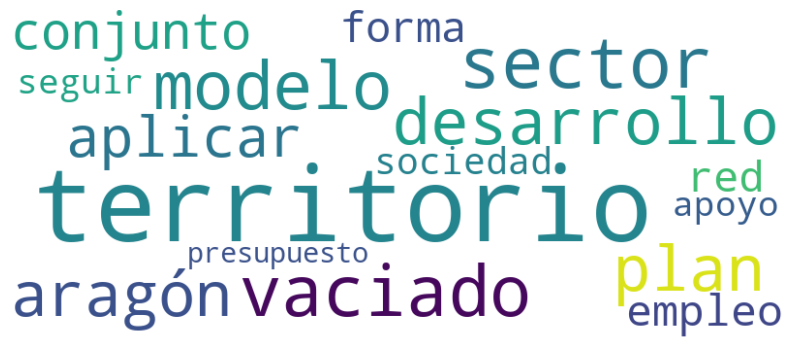

Palabra,PageRank,Comunidad,Palabra,PageRank,Comunidad
territorio,34.632328,23998,despoblación,21.054778,4126
rural,29.063128,4556,ejemplo,21.047031,12639
teruel,27.366514,12639,servicio,18.569140,4556
territorial,21.769290,4126,provincia,18.012166,12639
problema,21.493863,4126,empresa,16.810245,4556


Palabras que no encajan semánticamente con territorio: ['aplicar', 'aplicar', 'aplicar', 'aplicar', 'aplicar', 'aplicar', 'aplicar', 'aplicar', 'aplicar', 'aplicar', 'aplicar', 'aplicar', 'aplicar', 'aplicar', 'aplicar', 'aplicar', 'aplicar', 'aplicar', 'aplicar', 'aplicar', 'aplicar', 'aplicar', 'aplicar', 'aplicar', 'aplicar', 'aplicar', 'aplicar', 'aplicar', 'aplicar', 'aplicar', 'aplicar', 'aplicar', 'aplicar', 'aplicar', 'aplicar', 'aplicar', 'aplicar', 'aplicar', 'aplicar', 'aplicar', 'apoyo', 'apoyo', 'apoyo', 'apoyo', 'apoyo', 'apoyo', 'apoyo', 'apoyo', 'apoyo', 'apoyo', 'apoyo', 'apoyo', 'apoyo', 'apoyo', 'apoyo', 'apoyo', 'apoyo', 'apoyo', 'apoyo', 'apoyo', 'apoyo', 'apoyo', 'apoyo', 'apoyo', 'apoyo', 'apoyo', 'apoyo', 'apoyo', 'apoyo', 'apoyo', 'apoyo', 'apoyo', 'aragón', 'aragón', 'aragón', 'aragón', 'aragón', 'aragón', 'aragón', 'aragón', 'aragón', 'aragón', 'aragón', 'aragón', 'aragón', 'aragón', 'aragón', 'aragón', 'aragón', 'aragón', 'aragón', 'aragón', 'aragón', 'aragó

In [108]:
from bokeh.io import show, output_notebook, save
from bokeh.models import Plot, Range1d, MultiLine, Circle, HoverTool, TapTool, BoxSelectTool, ColumnDataSource
from bokeh.models.graphs import NodesAndLinkedEdges, EdgesAndLinkedNodes
from bokeh.palettes import Spectral4
from bokeh.plotting import from_networkx
import numpy as np
from bokeh.models import LabelSet
import networkx as nx
from bokeh.models import SaveTool
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from IPython.display import display, HTML, Image
import spacy


output_notebook()

colores_grupos = {
    'Grupo Parlamentario Ciudadanos':'#FF571F',
    'Grupo Parlamentario Confederal de Unidas Podemos-En Comú Podem-Galicia en Común':'#693279',
    'Grupo Parlamentario Popular en el Congreso': '#184A90',
    'Grupo Parlamentario Socialista': '#DC0612',
    'Grupo Parlamentario VOX': '#63BE21'
}
color_otro = '#ACB0B2'

lista_grupos = ['Grupo Parlamentario Ciudadanos', 
                'Grupo Parlamentario Confederal de Unidas Podemos-En Comú Podem-Galicia en Común',
                'Grupo Parlamentario Popular en el Congreso',
                'Grupo Parlamentario Socialista',
                'Grupo Parlamentario VOX'

               ]

G = nx.Graph()

#GCUP_EC_GC
grupo = 'GVOX'
fecha = 'TERUEL'
sw_global = True

if sw_global:
    archivo = f'PR_DISCURSO_{fecha}'
    df_comunidades = pd.read_csv(f'resultados_analisis\COM_DISCURSO_{fecha}.csv')
else:
    archivo = f'PR_DISCURSO_{fecha}_{grupo}'
    df_comunidades = pd.read_csv(f'resultados_analisis\COM_DISCURSO_{fecha}_{grupo}.csv')

df_proceso = pd.read_csv(f'resultados_analisis\{archivo}.csv')
df_proceso = df_proceso[df_proceso['grupo_parlamentario'].isin(lista_grupos)]
df_nube_palabras = df_proceso
palabras_frecuentes = df_proceso.groupby('palabra')['total'].max().reset_index()
palabras_frecuentes = palabras_frecuentes.sort_values(by='total', ascending=False)
top_palabras = palabras_frecuentes.head(20)['palabra'].tolist()
df_proceso = df_proceso[df_proceso['palabra'].isin(top_palabras)]
       
        
diccionario_grupo_parlamentario = df_proceso.groupby(['grupo_parlamentario'])['veces'].sum().reset_index().set_index('grupo_parlamentario')['veces'].to_dict()


def normalize_size(value, max_value, min_value):
    rango_max = 50
    rango_min = 5
    # Calculamos la proporción que representa value dentro del rango max_value-min_value
    prop = (value - min_value) / (max_value - min_value)
    # Calculamos el valor correspondiente en el rango 
    new_value = prop * (rango_max - rango_min) + rango_min
    # Devolvemos el resultado
    return new_value

max_total = df_proceso['total'].max()
min_total = df_proceso['total'].min()
max_veces = df_proceso['veces'].max()
min_veces = df_proceso['veces'].min()

for index, row in df_proceso.iterrows():
    if row["grupo_parlamentario"] not in G.nodes:
        size = normalize_size(diccionario_grupo_parlamentario[row["grupo_parlamentario"]], max(diccionario_grupo_parlamentario.values()), min(diccionario_grupo_parlamentario.values()) - 1)
        G.add_node(row["grupo_parlamentario"], size=size, tipo="grupo_parlamentario", nombre=row["grupo_parlamentario"], color=colores_grupos.get(row["grupo_parlamentario"], color_otro))
#        G.add_node(row["grupo_parlamentario"], size=20, tipo="grupo_parlamentario", nombre=row["grupo_parlamentario"], color=colores_grupos.get(row["grupo_parlamentario"], color_otro))
    if row["palabra"] not in G.nodes:
        G.add_node(row["palabra"], size=normalize_size(row["total"], max_total, min_total), tipo="palabra", palabra=row["palabra"], total=row["total"], color='white')
    G.add_edge(row["grupo_parlamentario"], row["palabra"], weight=row["veces"], color=colores_grupos.get(row["grupo_parlamentario"], color_otro))   

if sw_global:
    plot = Plot(plot_width=500, plot_height=500, 
                x_range=Range1d(-1.1, 1.1), y_range=Range1d(-1.1, 1.1),  background_fill_color='black')
else:
    plot = Plot(plot_width=800, plot_height=350, 
                x_range=Range1d(-1.1, 1.1), y_range=Range1d(-1.1, 1.1),  background_fill_color='black')

graph_renderer = from_networkx(G, nx.spring_layout(G, k=2), scale=1, center=(0, 0))

# Agrega nodos y enlaces al Plot
graph_renderer.node_renderer.data_source.data['fill_color'] = [node[1]['color'] for node in G.nodes(data=True)]
graph_renderer.node_renderer.glyph = Circle(size='size', fill_color='fill_color')

def make_line_width(weight, max_value):
    rango_max = 10
    rango_min = 1
    # Calculamos la proporción que representa value dentro del rango max_value-min_value
    prop = (weight - 1) / (max_value - 1)
    # Calculamos el valor correspondiente en el rango 5-50
    new_value = prop * (rango_max - rango_min) + rango_min
    # Devolvemos el resultado
    return new_value

graph_renderer.edge_renderer.data_source.data['line_width'] = [make_line_width(edge[2]['weight'], max_veces) for edge in G.edges(data=True)]
graph_renderer.edge_renderer.glyph = MultiLine(line_color='color', line_alpha=0.7, line_width='line_width')

plot.renderers.append(graph_renderer)

hover = HoverTool(tooltips=[("Tipo", "@tipo"),
                            ("Palabra", "@palabra"),
                            ("Nombre", "@nombre")])
plot.add_tools(hover, TapTool(), BoxSelectTool(), SaveTool())



#Add Labels
x, y = zip(*graph_renderer.layout_provider.graph_layout.values())
node_labels = list(G.nodes())
source = ColumnDataSource({'x': x, 'y': y, 'name': [node_labels[i] for i in range(len(x))]})
labels = LabelSet(x='x', y='y', text='name', source=source, background_fill_color='white', text_font_size='10px', background_fill_alpha=.7)
plot.renderers.append(labels)
print(archivo)
show(plot)
df_salida = df_proceso.groupby(['palabra'])['total'].max().reset_index().sort_values(by='total', ascending=False, inplace=False).head(40).reset_index().drop('index', axis=1)
df_salida = pd.merge(df_salida, df_comunidades, on='palabra')
df_salida = df_salida.drop('polaridad', axis=1)
#df_salida = pd.merge(df_salida, nuevas_polaridades, on='palabra')
df_nube = df_comunidades[df_comunidades['comunidad'] == df_salida.iloc[0]['comunidad']]
df_nube = pd.merge(df_nube, df_nube_palabras, on='palabra')
dict_records  = df_nube[['palabra', 'total']].drop_duplicates().to_dict('records')
dict_palabra_total = {}
for record in dict_records:
    dict_palabra_total[record['palabra']] = record['total']
    
# Crear el objeto WordCloud con el diccionario
wordcloud = WordCloud(width=800, height=350, background_color='white').generate_from_frequencies(dict_palabra_total)

# Mostrar la nube de palabras
plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

df = df_salida.head(10)
df = df.rename(columns={'palabra': 'Palabra', 'total': 'PageRank', 'comunidad': 'Comunidad'})
# Seleccionar las primeras 5 filas
df_left = df.iloc[:5]

# Seleccionar las últimas 5 filas
df_right = df.iloc[-5:]

# Concatenar los dos dataframes
df_display = pd.concat([df_left.reset_index(drop=True), df_right.reset_index(drop=True)], axis=1).to_html(index=False)

# Mostrar la tabla en el notebook
display(HTML(df_display))
#
# Carga el modelo de lenguaje que deseas utilizar
nlp = spacy.load("es_core_news_lg")

# Define una lista de palabras para analizar
palabras = df_nube['palabra'].to_list()

# Analiza cada palabra utilizando el objeto `nlp`
doc_palabras = [nlp(palabra) for palabra in palabras]

# Define una palabra de referencia para comparar con las demás palabras
palabra_referencia = nlp(df_salida.iloc[0]['palabra'])

# Crea una lista vacía para almacenar las palabras que no encajan semánticamente
palabras_no_encajan = []

# Itera sobre las palabras analizadas y compara su similitud semántica con la palabra de referencia
for palabra in doc_palabras:
    if palabra.similarity(palabra_referencia) < 0.5:
        # Agrega la palabra a la lista de palabras que no encajan semánticamente
        palabras_no_encajan.append(palabra.text)

# Imprime las palabras que no encajan semánticamente
# En algunas ocasiones la palabra más importante del discurso produce un vector vacío, en ese caso no se mostrarán las palabras
# diferentes porque son todas
if len(palabras) == len(palabras_no_encajan) + 1:
    print("No se han podido obtener diferencias semánticas")
else:
    print("Palabras que no encajan semánticamente con " + df_salida.iloc[0]['palabra'] + ":", palabras_no_encajan)
#

Loading BokehJS ...

PR_DISCURSO_TERUEL


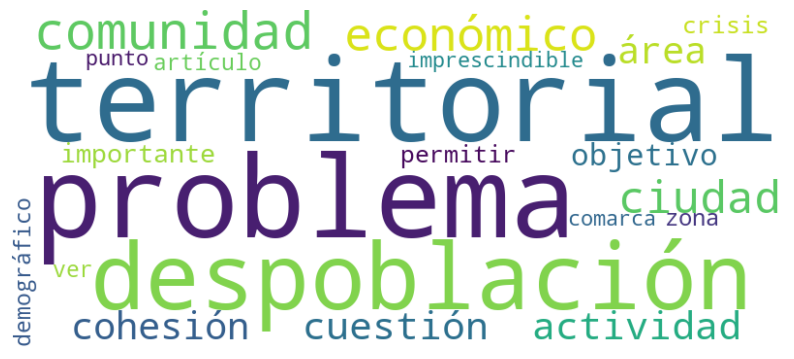

Palabra,PageRank,Comunidad,Palabra,PageRank,Comunidad
territorio,34.632328,23998,despoblación,21.054778,4126
rural,29.063128,4556,ejemplo,21.047031,12639
teruel,27.366514,12639,servicio,18.569140,4556
territorial,21.769290,4126,provincia,18.012166,12639
problema,21.493863,4126,empresa,16.810245,4556


Palabras que no encajan semánticamente con territorio: ['actividad', 'actividad', 'actividad', 'actividad', 'actividad', 'actividad', 'actividad', 'actividad', 'actividad', 'actividad', 'actividad', 'actividad', 'actividad', 'actividad', 'actividad', 'actividad', 'actividad', 'actividad', 'actividad', 'actividad', 'actividad', 'actividad', 'actividad', 'actividad', 'actividad', 'actividad', 'actividad', 'actividad', 'actividad', 'actividad', 'actividad', 'actividad', 'actividad', 'actividad', 'actividad', 'actividad', 'actividad', 'actividad', 'actividad', 'actividad', 'actividad', 'actividad', 'artículo', 'artículo', 'artículo', 'artículo', 'artículo', 'artículo', 'artículo', 'artículo', 'artículo', 'artículo', 'artículo', 'artículo', 'artículo', 'artículo', 'artículo', 'artículo', 'artículo', 'artículo', 'artículo', 'artículo', 'artículo', 'artículo', 'artículo', 'artículo', 'artículo', 'artículo', 'cohesión', 'cohesión', 'cohesión', 'cohesión', 'cohesión', 'cohesión', 'cohesión', 'c

In [112]:
from bokeh.io import show, output_notebook, save
from bokeh.models import Plot, Range1d, MultiLine, Circle, HoverTool, TapTool, BoxSelectTool, ColumnDataSource
from bokeh.models.graphs import NodesAndLinkedEdges, EdgesAndLinkedNodes
from bokeh.palettes import Spectral4
from bokeh.plotting import from_networkx
import numpy as np
from bokeh.models import LabelSet
import networkx as nx
from bokeh.models import SaveTool
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from IPython.display import display, HTML, Image
import spacy


output_notebook()

colores_grupos = {
    'Grupo Parlamentario Ciudadanos':'#FF571F',
    'Grupo Parlamentario Confederal de Unidas Podemos-En Comú Podem-Galicia en Común':'#693279',
    'Grupo Parlamentario Popular en el Congreso': '#184A90',
    'Grupo Parlamentario Socialista': '#DC0612',
    'Grupo Parlamentario VOX': '#63BE21'
}
color_otro = '#ACB0B2'

lista_grupos = ['Grupo Parlamentario Ciudadanos', 
                'Grupo Parlamentario Confederal de Unidas Podemos-En Comú Podem-Galicia en Común',
                'Grupo Parlamentario Popular en el Congreso',
                'Grupo Parlamentario Socialista',
                'Grupo Parlamentario VOX',
                'Grupo Parlamentario Mixto'

               ]

G = nx.Graph()

#GCUP_EC_GC
grupo = 'GVOX'
fecha = 'TERUEL'
sw_global = True

if sw_global:
    archivo = f'PR_DISCURSO_{fecha}'
    df_comunidades = pd.read_csv(f'resultados_analisis\COM_DISCURSO_{fecha}.csv')
else:
    archivo = f'PR_DISCURSO_{fecha}_{grupo}'
    df_comunidades = pd.read_csv(f'resultados_analisis\COM_DISCURSO_{fecha}_{grupo}.csv')

df_proceso = pd.read_csv(f'resultados_analisis\{archivo}.csv')
df_proceso = df_proceso[df_proceso['grupo_parlamentario'].isin(lista_grupos)]
df_nube_palabras = df_proceso
palabras_frecuentes = df_proceso.groupby('palabra')['total'].max().reset_index()
palabras_frecuentes = palabras_frecuentes.sort_values(by='total', ascending=False)
top_palabras = palabras_frecuentes.head(20)['palabra'].tolist()
df_proceso = df_proceso[df_proceso['palabra'].isin(top_palabras)]
       
        
diccionario_grupo_parlamentario = df_proceso.groupby(['grupo_parlamentario'])['veces'].sum().reset_index().set_index('grupo_parlamentario')['veces'].to_dict()


def normalize_size(value, max_value, min_value):
    rango_max = 50
    rango_min = 5
    # Calculamos la proporción que representa value dentro del rango max_value-min_value
    prop = (value - min_value) / (max_value - min_value)
    # Calculamos el valor correspondiente en el rango 
    new_value = prop * (rango_max - rango_min) + rango_min
    # Devolvemos el resultado
    return new_value

max_total = df_proceso['total'].max()
min_total = df_proceso['total'].min()
max_veces = df_proceso['veces'].max()
min_veces = df_proceso['veces'].min()

for index, row in df_proceso.iterrows():
    if row["grupo_parlamentario"] not in G.nodes:
        size = normalize_size(diccionario_grupo_parlamentario[row["grupo_parlamentario"]], max(diccionario_grupo_parlamentario.values()), min(diccionario_grupo_parlamentario.values()) - 1)
        G.add_node(row["grupo_parlamentario"], size=size, tipo="grupo_parlamentario", nombre=row["grupo_parlamentario"], color=colores_grupos.get(row["grupo_parlamentario"], color_otro))
#        G.add_node(row["grupo_parlamentario"], size=20, tipo="grupo_parlamentario", nombre=row["grupo_parlamentario"], color=colores_grupos.get(row["grupo_parlamentario"], color_otro))
    if row["palabra"] not in G.nodes:
        G.add_node(row["palabra"], size=normalize_size(row["total"], max_total, min_total), tipo="palabra", palabra=row["palabra"], total=row["total"], color='white')
    G.add_edge(row["grupo_parlamentario"], row["palabra"], weight=row["veces"], color=colores_grupos.get(row["grupo_parlamentario"], color_otro))   

if sw_global:
    plot = Plot(plot_width=500, plot_height=500, 
                x_range=Range1d(-1.1, 1.1), y_range=Range1d(-1.1, 1.1),  background_fill_color='black')
else:
    plot = Plot(plot_width=800, plot_height=350, 
                x_range=Range1d(-1.1, 1.1), y_range=Range1d(-1.1, 1.1),  background_fill_color='black')

graph_renderer = from_networkx(G, nx.spring_layout(G, k=2), scale=1, center=(0, 0))

# Agrega nodos y enlaces al Plot
graph_renderer.node_renderer.data_source.data['fill_color'] = [node[1]['color'] for node in G.nodes(data=True)]
graph_renderer.node_renderer.glyph = Circle(size='size', fill_color='fill_color')

def make_line_width(weight, max_value):
    rango_max = 10
    rango_min = 1
    # Calculamos la proporción que representa value dentro del rango max_value-min_value
    prop = (weight - 1) / (max_value - 1)
    # Calculamos el valor correspondiente en el rango 5-50
    new_value = prop * (rango_max - rango_min) + rango_min
    # Devolvemos el resultado
    return new_value

graph_renderer.edge_renderer.data_source.data['line_width'] = [make_line_width(edge[2]['weight'], max_veces) for edge in G.edges(data=True)]
graph_renderer.edge_renderer.glyph = MultiLine(line_color='color', line_alpha=0.7, line_width='line_width')

plot.renderers.append(graph_renderer)

hover = HoverTool(tooltips=[("Tipo", "@tipo"),
                            ("Palabra", "@palabra"),
                            ("Nombre", "@nombre")])
plot.add_tools(hover, TapTool(), BoxSelectTool(), SaveTool())



#Add Labels
x, y = zip(*graph_renderer.layout_provider.graph_layout.values())
node_labels = list(G.nodes())
source = ColumnDataSource({'x': x, 'y': y, 'name': [node_labels[i] for i in range(len(x))]})
labels = LabelSet(x='x', y='y', text='name', source=source, background_fill_color='white', text_font_size='10px', background_fill_alpha=.7)
plot.renderers.append(labels)
print(archivo)
show(plot)
df_salida = df_proceso.groupby(['palabra'])['total'].max().reset_index().sort_values(by='total', ascending=False, inplace=False).head(40).reset_index().drop('index', axis=1)
df_salida = pd.merge(df_salida, df_comunidades, on='palabra')
df_salida = df_salida.drop('polaridad', axis=1)
#df_salida = pd.merge(df_salida, nuevas_polaridades, on='palabra')
df_nube = df_comunidades[df_comunidades['comunidad'] == df_salida.iloc[3]['comunidad']]
df_nube = pd.merge(df_nube, df_nube_palabras, on='palabra')
dict_records  = df_nube[['palabra', 'total']].drop_duplicates().to_dict('records')
dict_palabra_total = {}
for record in dict_records:
    dict_palabra_total[record['palabra']] = record['total']
    
# Crear el objeto WordCloud con el diccionario
wordcloud = WordCloud(width=800, height=350, background_color='white').generate_from_frequencies(dict_palabra_total)

# Mostrar la nube de palabras
plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

df = df_salida.head(10)
df = df.rename(columns={'palabra': 'Palabra', 'total': 'PageRank', 'comunidad': 'Comunidad'})
# Seleccionar las primeras 5 filas
df_left = df.iloc[:5]

# Seleccionar las últimas 5 filas
df_right = df.iloc[-5:]

# Concatenar los dos dataframes
df_display = pd.concat([df_left.reset_index(drop=True), df_right.reset_index(drop=True)], axis=1).to_html(index=False)

# Mostrar la tabla en el notebook
display(HTML(df_display))
#
# Carga el modelo de lenguaje que deseas utilizar
nlp = spacy.load("es_core_news_lg")

# Define una lista de palabras para analizar
palabras = df_nube['palabra'].to_list()

# Analiza cada palabra utilizando el objeto `nlp`
doc_palabras = [nlp(palabra) for palabra in palabras]

# Define una palabra de referencia para comparar con las demás palabras
palabra_referencia = nlp(df_salida.iloc[0]['palabra'])

# Crea una lista vacía para almacenar las palabras que no encajan semánticamente
palabras_no_encajan = []

# Itera sobre las palabras analizadas y compara su similitud semántica con la palabra de referencia
for palabra in doc_palabras:
    if palabra.similarity(palabra_referencia) < 0.5:
        # Agrega la palabra a la lista de palabras que no encajan semánticamente
        palabras_no_encajan.append(palabra.text)

# Imprime las palabras que no encajan semánticamente
# En algunas ocasiones la palabra más importante del discurso produce un vector vacío, en ese caso no se mostrarán las palabras
# diferentes porque son todas
if len(palabras) == len(palabras_no_encajan) + 1:
    print("No se han podido obtener diferencias semánticas")
else:
    print("Palabras que no encajan semánticamente con " + df_salida.iloc[0]['palabra'] + ":", palabras_no_encajan)
#

In [74]:
0.07215334153274382 < 0.5

True

In [28]:
import spacy

# Carga el modelo de lenguaje que deseas utilizar
nlp = spacy.load("es_core_news_lg")

# Define una lista de palabras para analizar
palabras = df_nube['palabra'].to_list()

# Analiza cada palabra utilizando el objeto `nlp`
doc_palabras = [nlp(palabra) for palabra in palabras]

# Define una palabra de referencia para comparar con las demás palabras
palabra_referencia = nlp(df_salida.iloc[0]['palabra'])

# Crea una lista vacía para almacenar las palabras que no encajan semánticamente
palabras_no_encajan = []

# Itera sobre las palabras analizadas y compara su similitud semántica con la palabra de referencia
for palabra in doc_palabras:
    if palabra.similarity(palabra_referencia) < 0.5:
        # Agrega la palabra a la lista de palabras que no encajan semánticamente
        palabras_no_encajan.append(palabra.text)

# Imprime las palabras que no encajan semánticamente
print("Palabras que no encajan semánticamente con " + df_salida.iloc[0]['palabra'] + ":", palabras_no_encajan)


Palabras que no encajan semánticamente con familia: ['agresión', 'contar', 'disfrutar', 'ejemplo', 'encontrar', 'establecer', 'evidente', 'gracias', 'guerra', 'haber', 'justicia', 'menor', 'monoparental', 'parto', 'permiso', 'personal', 'poder', 'protección', 'reconocer', 'semana', 'servicio', 'señalar', 'situación', 'tener', 'texto']


In [27]:
df_salida.iloc[0]['palabra']

'familia'

In [66]:
df = df_salida.head(10)
df = df.rename(columns={'palabra': 'Palabra', 'total': 'PageRank', 'comunidad': 'Comunidad'})
# Seleccionar las primeras 5 filas
df_left = df.iloc[:5]

# Seleccionar las últimas 5 filas
df_right = df.iloc[-5:]

# Concatenar los dos dataframes
df_display = pd.concat([df_left.reset_index(drop=True), df_right.reset_index(drop=True)], axis=1)

# Mostrar la tabla en el notebook
display(df_display)


,Palabra,PageRank,Comunidad,Palabra,PageRank,Comunidad
0,ciudadanos,63.799610,11157,problema,44.783434,14422
1,hablar,52.144559,71,poder,42.828670,2
2,enmienda,49.532469,11157,situación,39.627945,71
3,creer,45.918737,2,pedir,39.344560,11157
4,ver,45.032109,66,cosa,39.319098,11157


In [47]:
df_nube_palabras[['palabra', 'total']].drop_duplicates()

,palabra,total
0,vox,74.764810
227,ministro,49.063777
412,ministra,48.931933
585,político,47.706869
797,sánchez,47.566248
...,...,...
17406,izquierda,19.260671
17568,necesitar,19.240007
17749,necesario,19.136268
17927,traer,19.078728


In [146]:
df_nube

,palabra,polaridad,comunidad,grupo_parlamentario,veces,fecha,total
0,ap,0.3,2203,Grupo Parlamentario Confederal de Unidas Podem...,21,2021-02-02,8.893588
1,artículo,0.0,2203,Grupo Parlamentario Confederal de Unidas Podem...,3,2021-02-02,1.486656
2,conflicto,0.0,2203,Grupo Parlamentario Confederal de Unidas Podem...,3,2021-02-02,1.618850
3,conocimiento,0.3,2203,Grupo Parlamentario Confederal de Unidas Podem...,7,2021-02-02,2.764032
4,galicia,0.3,2203,Grupo Parlamentario Confederal de Unidas Podem...,15,2021-02-02,7.542489
5,gallego,0.3,2203,Grupo Parlamentario Confederal de Unidas Podem...,5,2021-02-02,2.358918
6,infraestructura,0.0,2203,Grupo Parlamentario Confederal de Unidas Podem...,5,2021-02-02,2.029823
7,sector,-0.1,2203,Grupo Parlamentario Confederal de Unidas Podem...,10,2021-02-02,4.582861
8,transferencia,0.3,2203,Grupo Parlamentario Confederal de Unidas Podem...,19,2021-02-02,8.415978


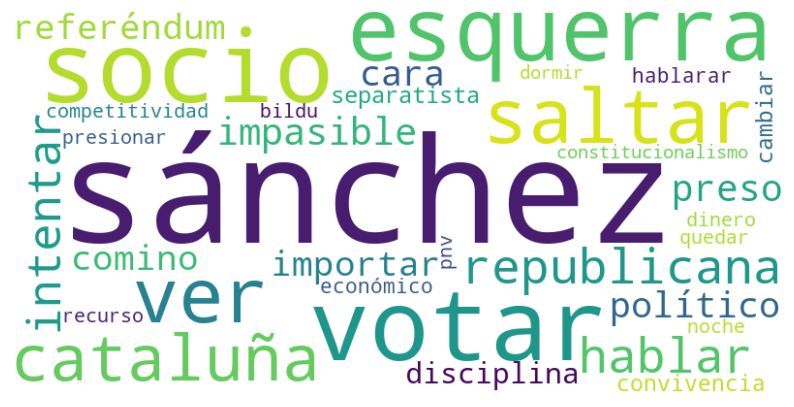

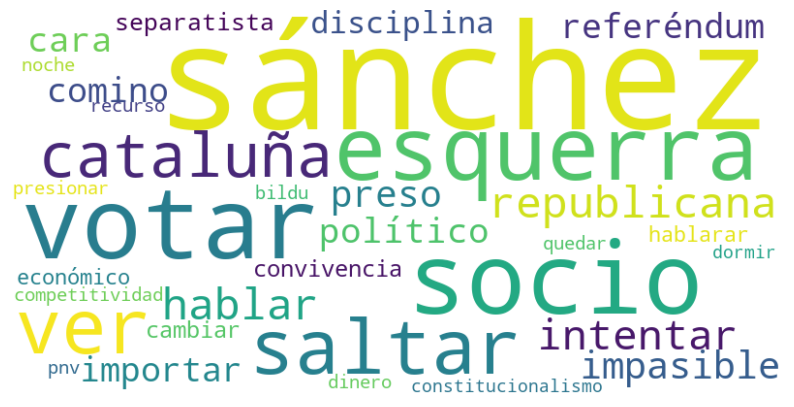

In [109]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt


